## Select closest points using CKDTree

To select closest grid points, we will use here one approach using [cKDTree](http://docs.scipy.org/doc/scipy-0.12.0/reference/generated/scipy.spatial.cKDTree.html) class from scipy.spatial package.

Two methods of interpolation are considered here: nearest neighbour and weighting with the inverse of distance squared:

$T_t = frac{\\sum_{i=1}^{m}T_{s,i}w_i}{\\sum_{i=1}^{m}w_i}$, $w_i = 1/d_i^2$).


In [2]:
#for Netcdf manipulation
import xarray as xr

#for array manipulation
import numpy as np
import pandas as pd

#for plotting

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib
import matplotlib.pylab as plt

#for interpolation
from scipy.spatial import cKDTree

import warnings
warnings.filterwarnings("ignore")

First we load Netcdf data.

In [3]:
unique_dataDIR = 'K:/PROJETS/PROJET_FIRE_INDEX/ERA5_FWI_Netcdf/ERA5_FWI_QC_SNOW_New_2018_from_4_to_8.nc'
TAS = xr.open_dataset(unique_dataDIR)

In [4]:
lon2d, lat2d = np.meshgrid(TAS.lon, TAS.lat)

In [5]:
class KDTreeIndex():
    
    """ A KD-tree implementation for fast point lookup on a 2D grid
    
    Keyword arguments: 
    dataset -- a xarray DataArray containing lat/lon coordinates
               (named 'lat' and 'lon' respectively)
               
    """
    
    def transform_coordinates(self, coords):
        """ Transform coordinates from geodetic to cartesian
        
        Keyword arguments:
        coords - a set of lan/lon coordinates (e.g. a tuple or 
                 an array of tuples)
        """
        # WGS 84 reference coordinate system parameters
        A = 6378.137 # major axis [km]   
        E2 = 6.69437999014e-3 # eccentricity squared    
        
        coords = np.asarray(coords).astype(np.float)
        
        # is coords a tuple? Convert it to an one-element array of tuples
        if coords.ndim == 1:
            coords = np.array([coords])
        
        # convert to radiants
        lat_rad = np.radians(coords[:,0])
        lon_rad = np.radians(coords[:,1]) 
        
        # convert to cartesian coordinates
        r_n = A / (np.sqrt(1 - E2 * (np.sin(lat_rad) ** 2)))
        x = r_n * np.cos(lat_rad) * np.cos(lon_rad)
        y = r_n * np.cos(lat_rad) * np.sin(lon_rad)
        z = r_n * (1 - E2) * np.sin(lat_rad)
        
        return np.column_stack((x, y, z))
    
    def __init__(self, dataset):
        # store original dataset shape
        self.shape = dataset.shape
        lon2d, lat2d = np.meshgrid(dataset.lon, dataset.lat)
        # reshape and stack coordinates
        coords = np.column_stack((lat2d.ravel(),
                                  lon2d.ravel()))
        
        # construct KD-tree
        self.tree = cKDTree(self.transform_coordinates(coords))
        
    def query(self, point, k):
        """ Query the kd-tree for nearest neighbour.

        Keyword arguments:
        point -- a (lat, lon) tuple or array of tuples
        """
        d, inds  = self.tree.query(self.transform_coordinates(point),k=k)
        w = 1.0 / d**2
        # regrid to 2D grid
        indslatlon = np.unravel_index(inds, self.shape)
        # return DataArray indexers
        return d, inds, w, indslatlon
       # return xr.DataArray(index[0], dims='pixel'), \
       #        xr.DataArray(index[1], dims='pixel')

In [6]:
ground_pixel_tree = KDTreeIndex(TAS.sel(time='2018-08-01').FWI)

In [7]:
stations = pd.read_csv("K:/PROJETS/PROJET_FIRE_INDEX/database_stations/Stations_latlon_in_2018.csv", sep=",")
stations.head()

,NoStation,latD,lonD
0,111,45.6222,-76.0192
1,129,45.2942,-73.3489
2,132,47.1564,-78.9339
3,142,46.0853,-76.5511
4,145,46.6947,-78.0611


## Working with one station

Select k=10closest points:

In [8]:
site = stations['latD'][0], stations['lonD'][0]
d, inds, w, indslatlon = ground_pixel_tree.query(site, k=10)
print(d)
print(w)
print(inds)
print(indslatlon)

[[13.6641132  14.28288035 22.56450988 22.91330845 25.02377797 25.32850203
  39.91905153 40.05725904 41.39361796 42.01800725]]
[[0.00535596 0.00490194 0.00196403 0.00190469 0.00159696 0.00155877
  0.00062754 0.00062321 0.00058362 0.00056641]]
[[8018 7897 8017 7896 8019 7898 8016 7895 8139 7776]]
(array([[66, 65, 66, 65, 66, 65, 66, 65, 67, 64]], dtype=int64), array([[32, 32, 31, 31, 33, 33, 30, 30, 32, 32]], dtype=int64))


Loop over each day from our dataset: 

In [9]:
FWI_kpts = []
FWI_kpts_model = pd.DataFrame()
i=1
for day in TAS.time: 
    FWI_kpts.append((np.nansum(w * TAS.sel(time=day).FWI.values.flatten()[inds], axis=1) / np.nansum(w, axis=1))[0])
FWI_kpts_model[str(i)] = FWI_kpts
FWI_kpts_model['Date'] = TAS.time
FWI_kpts_model = FWI_kpts_model.set_index('Date')
FWI_kpts_model.tail()

,1
Date,
2018-08-27,0.506486
2018-08-28,1.851446
2018-08-29,0.355044
2018-08-30,0.192298
2018-08-31,1.182098


## Loop over all stations using stations' index

In [10]:
stations = pd.read_csv("K:/PROJETS/PROJET_FIRE_INDEX/database_stations/Stations_latlon_in_2018.csv", sep=",")
FWI_kpts_model = pd.DataFrame()
for i, row in stations.iterrows(): 
    site = row['latD'], row['lonD']
    d, inds, w, indslatlon = ground_pixel_tree.query(site, k=10)
    FWI_kpts = []    
    for day in TAS.time: 
        FWI_kpts.append((np.nansum(w * TAS.sel(time=day).FWI.values.flatten()[inds], axis=1) / np.nansum(w, axis=1))[0])
    FWI_kpts_model[str(int(row[0]))] = FWI_kpts
    
FWI_kpts_model['Date'] = TAS.time
FWI_kpts_model = FWI_kpts_model.set_index('Date')
FWI_kpts_model.to_csv("K:/PROJETS/PROJET_FIRE_INDEX/Closest_points/FWI_kpts_model_2018.csv", header = True, sep = ',') 
FWI_kpts_model.head()

,111,129,132,142,145,151,152,156,161,162,...,775,776,777,778,779,787,789,792,793,794
Date,,,,,,,,,,,,,,,,,,,,,
2018-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-04-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-04-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-04-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-04-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Open FWI computed over stations 

In [11]:
dataframe = pd.read_csv("K:/PROJETS/PROJET_FIRE_INDEX/database_stations/Stations_FWI_SOPFEU2018.csv", encoding='latin-1')
dataframe = dataframe.set_index('Date')
dataframe.head()

,111,129,132,142,145,151,152,156,161,162,...,775,776,777,778,779,787,789,792,793,794
Date,,,,,,,,,,,,,,,,,,,,,
2018-04-01,0.5,5.8,5.7,0.2,3.2,0.5,0.3,2.0,5.7,1.1,...,2.8,7.9,7.3,3.5,0.6,3.6,4.4,4.2,3.2,0.6
2018-04-02,0.6,4.0,10.5,0.4,4.8,0.6,0.4,0.1,8.2,0.9,...,0.6,7.3,12.7,0.3,0.2,3.9,1.2,4.7,0.8,0.4
2018-04-03,0.8,3.7,0.0,0.4,8.4,0.7,0.5,0.1,7.7,1.1,...,0.6,0.7,0.0,0.9,0.5,3.7,0.6,13.5,1.6,0.8
2018-04-04,0.0,0.0,0.1,0.5,11.8,0.8,0.5,0.2,10.8,0.0,...,0.8,0.0,0.0,0.6,0.4,5.0,2.4,4.1,0.9,1.4
2018-04-05,0.0,0.0,0.0,0.8,10.6,0.4,0.9,0.4,2.1,0.0,...,0.0,0.1,0.1,1.5,0.0,0.4,0.0,1.0,0.0,1.6


## Select time range using ERA5 Onset 

In [12]:
unique_dataDIR = 'K:/PROJETS/PROJET_FIRE_INDEX/ERA5_Onset_Netcdf/ERA5_SNOW_Onset_2018_from_4_to_8.nc'
VAR = xr.open_dataset(unique_dataDIR) 

In [13]:
stations = pd.read_csv("K:/PROJETS/PROJET_FIRE_INDEX/database_stations/Stations_latlon_in_2018.csv", sep=",")
ERA5_Onset = []   
for i, row in stations.iterrows(): 
    site = row['latD'], row['lonD']
    d, inds, w, indslatlon = ground_pixel_tree.query(site, k=10)   
    ERA5_Onset.append(int(np.round(np.nansum(w * VAR.Onset.values.flatten()[inds], axis=1) / np.nansum(w, axis=1))[0]))

In [14]:
ERA5_Onset = pd.DataFrame(ERA5_Onset)
import datetime
from datetime import timedelta
datetime.date(2018, 4, 1)
ERA5_Onset = pd.DataFrame(ERA5_Onset)
ERA5_Onset['Date'] = ERA5_Onset[0].apply(lambda x: datetime.date(2018, 4, 1) + timedelta(days=x))
ERA5_Onset.head()

,0,Date
0,28,2018-04-29
1,24,2018-04-25
2,37,2018-05-08
3,31,2018-05-02
4,37,2018-05-08


We will filter our dataset using Onset. 

In [15]:
dataframe_stations = pd.read_csv("K:/PROJETS/PROJET_FIRE_INDEX/database_stations/Stations_FWI_SOPFEU2018.csv", encoding='latin-1')
dataframe_stations = dataframe_stations.set_index('Date')

i = 0 
for column in dataframe_stations:
    dataframe_stations[column] = dataframe_stations[column].loc[ERA5_Onset['Date'][i].strftime('%Y-%m-%d'):'2018-08-31']
    i+=1
    
i = 0 
for column in FWI_kpts_model:
    FWI_kpts_model[column] = FWI_kpts_model[column].loc[ERA5_Onset['Date'][i].strftime('%Y-%m-%d'):'2018-08-31']
    i+=1

## Make correlation between two DataFrames

In [16]:
df_corr_stations_ERA5 = pd.DataFrame()
df_corr_stations_ERA5['Correlation'] = dataframe_stations.corrwith(other=FWI_kpts_model, method='pearson')
df_corr_stations_ERA5['Lat'] = stations.latD.values
df_corr_stations_ERA5['Lon'] = stations.lonD.values
df_corr_stations_ERA5.head()

,Correlation,Lat,Lon
111,0.863683,45.6222,-76.0192
129,0.779444,45.2942,-73.3489
132,0.006643,47.1564,-78.9339
142,0.818676,46.0853,-76.5511
145,0.341514,46.6947,-78.0611


### Correlation using Scipy library
The <b> stats </b> module of the <b> Scipy library </b> has many statistical functions.
https://docs.scipy.org/doc/scipy/reference/stats.html

In [17]:
from scipy import stats
df_correlation = pd.DataFrame()
df_pvalue = pd.DataFrame()
corr_pearson_ERA5 = []
p_pearson_ERA5 = []
corr_spearman_ERA5 = []
p_spearman_ERA5 = []
corr_kendall_ERA5 = []
p_kendall_ERA5 = []

for i in range(0,len(dataframe_stations.columns)): 
    # Kendall correlation
    r1, p1 = stats.kendalltau(dataframe_stations.iloc[:,i],FWI_kpts_model.iloc[:,i], nan_policy='omit')     
    corr_kendall_ERA5.append(r1)
    p_kendall_ERA5.append(p1)
    
    # pearson correlation
    r2, p2 = stats.pearsonr(dataframe_stations.iloc[:,i].dropna(axis=0, how='any'),FWI_kpts_model.iloc[:,i].dropna(axis=0, how='any'))     
    corr_pearson_ERA5.append(r2)
    p_pearson_ERA5.append(p2)
    
    # spearman correlation    
    r3, p3 = stats.spearmanr(dataframe_stations.iloc[:,i],FWI_kpts_model.iloc[:,i], nan_policy='omit')     
    corr_spearman_ERA5.append(r3)
    p_spearman_ERA5.append(p3)  

df_correlation['tau'] = corr_kendall_ERA5
df_correlation['p_kendall'] = p_kendall_ERA5
df_correlation['r_pearson'] = corr_pearson_ERA5
df_correlation['p_pearson'] = p_pearson_ERA5
df_correlation['r_spearman'] = corr_spearman_ERA5
df_correlation['p_spearman'] = p_spearman_ERA5
df_correlation['Lat'] = stations.latD.values
df_correlation['Lon'] = stations.lonD.values    

In [18]:
df_correlation['r_pearson'][(df_correlation['p_spearman'] < 0.1)]

0      0.863683
1      0.779444
3      0.818676
4      0.341514
6      0.870894
7      0.779158
13     0.803349
15     0.814070
19    -0.199450
24     0.810364
25     0.795711
26     0.778488
27     0.264959
30     0.513587
31     0.820978
33    -0.227812
34     0.749420
37     0.431689
38     0.801620
39    -0.187552
41     0.137151
42     0.766722
46     0.725307
48     0.137328
49     0.829187
50     0.842403
51     0.366000
52     0.754131
53     0.687330
56     0.791854
         ...   
94    -0.104630
95     0.817818
96     0.864498
98     0.779066
101    0.829813
104    0.706586
105    0.193361
106    0.640970
108    0.824920
110    0.841238
111    0.862142
112    0.061892
114    0.805523
118    0.770505
119    0.563838
121    0.215533
122    0.362473
124    0.671524
128    0.762353
130    0.488051
131   -0.176941
132    0.742685
133    0.869513
137    0.846235
138    0.704361
144    0.748243
145    0.755621
146    0.722261
147    0.033003
148    0.849495
Name: r_pearson, Length:

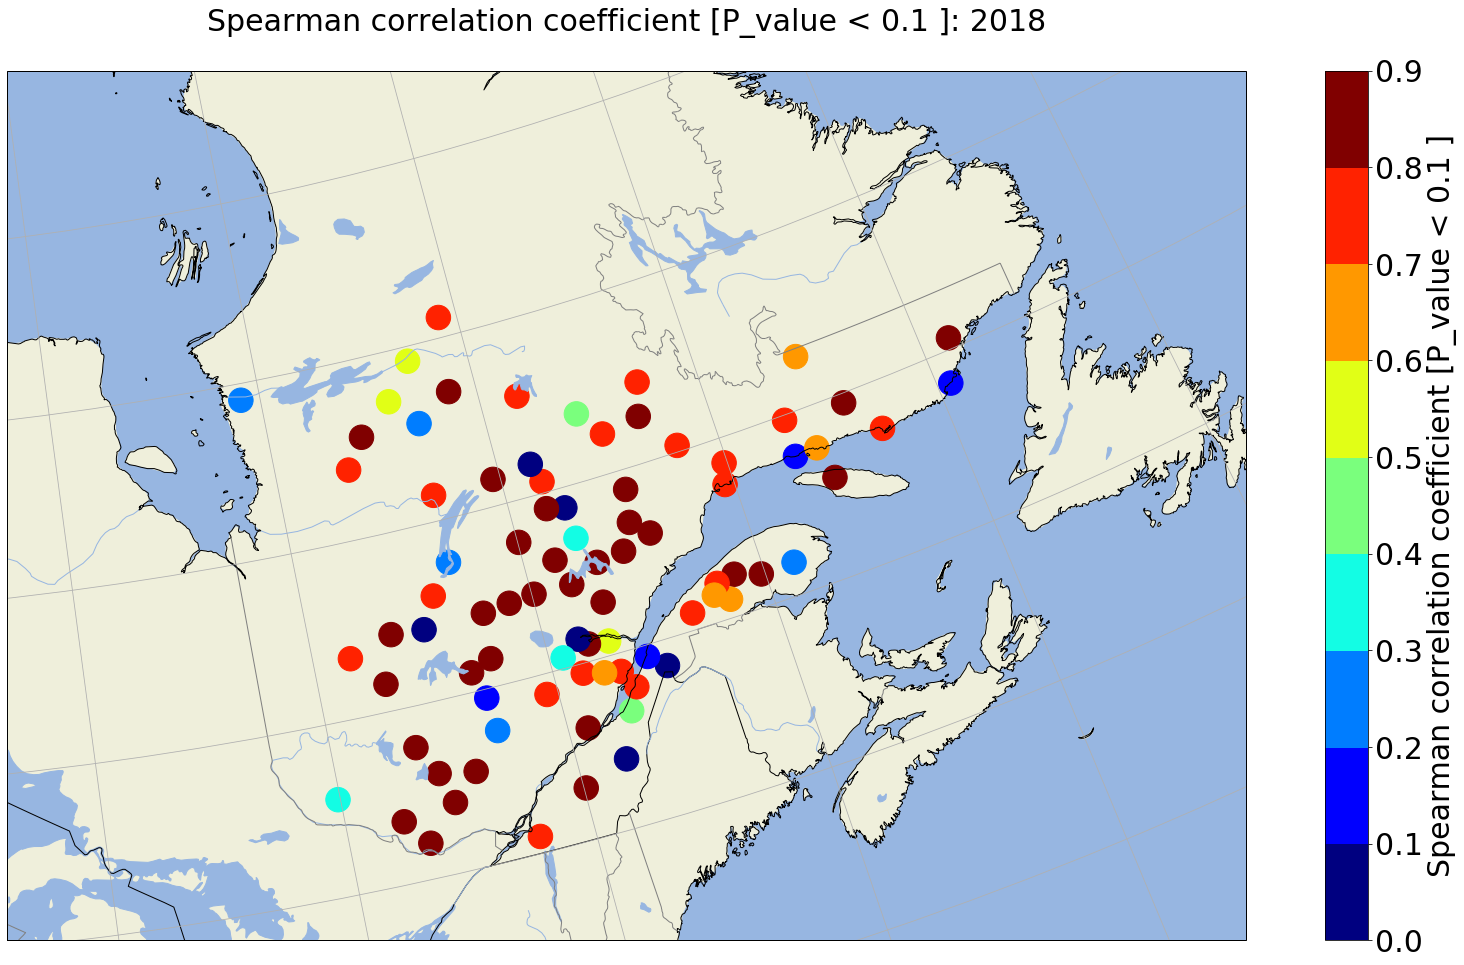

In [19]:
fig=plt.figure(figsize=(28,16), frameon=True) 
ax = plt.subplot(111, projection=ccrs.LambertConformal())
ax.set_extent([-85,-55,45,55])
 #ax.coastlines(resolution='110m');
ax.add_feature(cfeature.OCEAN.with_scale('50m'))      # couche ocean
ax.add_feature(cfeature.LAND.with_scale('50m'))       # couche land
ax.add_feature(cfeature.LAKES.with_scale('50m'))      # couche lac
  
ax.add_feature(cfeature.BORDERS.with_scale('50m'))    # couche frontieres
ax.add_feature(cfeature.RIVERS.with_scale('50m'))     # couche rivières
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',     # ajout de la couche cotière
                            facecolor='none', name='coastline')
ax.add_feature(coast, edgecolor='black')   
states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='10m',
            facecolor='none')
   
ax.add_feature(states_provinces, edgecolor='gray')

cmap = plt.cm.jet  # define the colormap
norm = matplotlib.colors.BoundaryNorm(np.arange(0,1,0.1), cmap.N)

# Plots the data onto map
plt.scatter(df_correlation['Lon'][(df_correlation['p_spearman'] < 0.1)], 
            df_correlation['Lat'][(df_correlation['p_spearman'] < 0.1)],
            alpha=1.,
            s=600, label="SR",
            c=df_correlation['r_spearman'][(df_correlation['p_spearman'] < 0.1)],
            vmin=0,
            vmax=1,
            cmap=plt.get_cmap("jet"),
            norm=norm,
            transform=ccrs.PlateCarree())
       
ax.gridlines()
# Colorbar
fwi = df_corr_stations_ERA5['Correlation']
#tick_values = np.linspace(fwi.min(), fwi.max(), 11)
cbar = plt.colorbar()
#cbar.ax.set_yticklabels(["%d"%(v) for v in tick_values], fontsize=14)
cbar.set_label('Spearman correlation coefficient [P_value < 0.1 ]', fontsize=30)
string_title=u'Spearman correlation coefficient [P_value < 0.1 ]: 2018\n'
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontsize=30)

plt.title(string_title, size='xx-large', fontsize=30)
plt.savefig('K:/PROJETS/PROJET_FIRE_INDEX/figures/SOPFEU_Stations_in_Quebec_Spearman_Correlation_2018.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

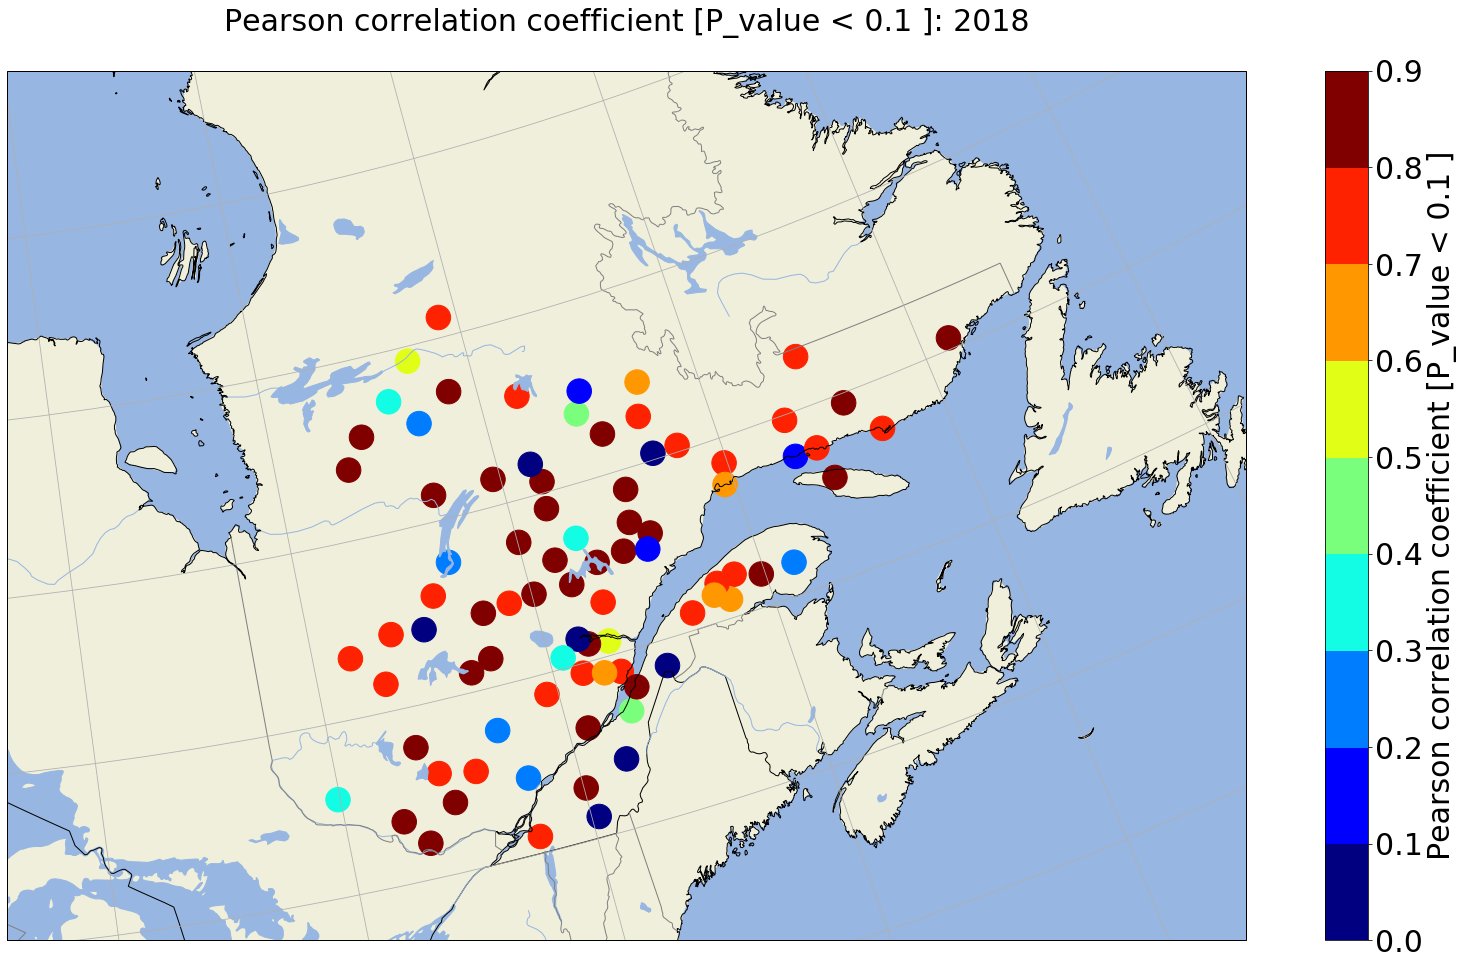

In [20]:
fig=plt.figure(figsize=(28,16), frameon=True) 
ax = plt.subplot(111, projection=ccrs.LambertConformal())
ax.set_extent([-85,-55,45,55])
 #ax.coastlines(resolution='110m');
ax.add_feature(cfeature.OCEAN.with_scale('50m'))      # couche ocean
ax.add_feature(cfeature.LAND.with_scale('50m'))       # couche land
ax.add_feature(cfeature.LAKES.with_scale('50m'))      # couche lac
  
ax.add_feature(cfeature.BORDERS.with_scale('50m'))    # couche frontieres
ax.add_feature(cfeature.RIVERS.with_scale('50m'))     # couche rivières
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',     # ajout de la couche cotière
                            facecolor='none', name='coastline')
ax.add_feature(coast, edgecolor='black')   
states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='10m',
            facecolor='none')
   
ax.add_feature(states_provinces, edgecolor='gray')

cmap = plt.cm.jet  # define the colormap
norm = matplotlib.colors.BoundaryNorm(np.arange(0,1,0.1), cmap.N)

# Plots the data onto map
plt.scatter(df_correlation['Lon'][(df_correlation['p_pearson'] < 0.1)], 
            df_correlation['Lat'][(df_correlation['p_pearson'] < 0.1)],
            alpha=1.,
            s=600, label="SR",
            c=df_correlation['r_pearson'][(df_correlation['p_pearson'] < 0.1)],
            vmin=0,
            vmax=1,
            cmap=plt.get_cmap("jet"),
            norm=norm,
            transform=ccrs.PlateCarree())
       
ax.gridlines()
# Colorbar
fwi = df_corr_stations_ERA5['Correlation']
#tick_values = np.linspace(fwi.min(), fwi.max(), 11)
cbar = plt.colorbar()
#cbar.ax.set_yticklabels(["%d"%(v) for v in tick_values], fontsize=14)
cbar.set_label('Pearson correlation coefficient [P_value < 0.1 ]', fontsize=30)
string_title=u'Pearson correlation coefficient [P_value < 0.1 ]: 2018\n'
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontsize=30)

plt.title(string_title, size='xx-large', fontsize=30)
plt.savefig('K:/PROJETS/PROJET_FIRE_INDEX/figures/SOPFEU_Stations_in_Quebec_Pearson_Correlation_2018.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

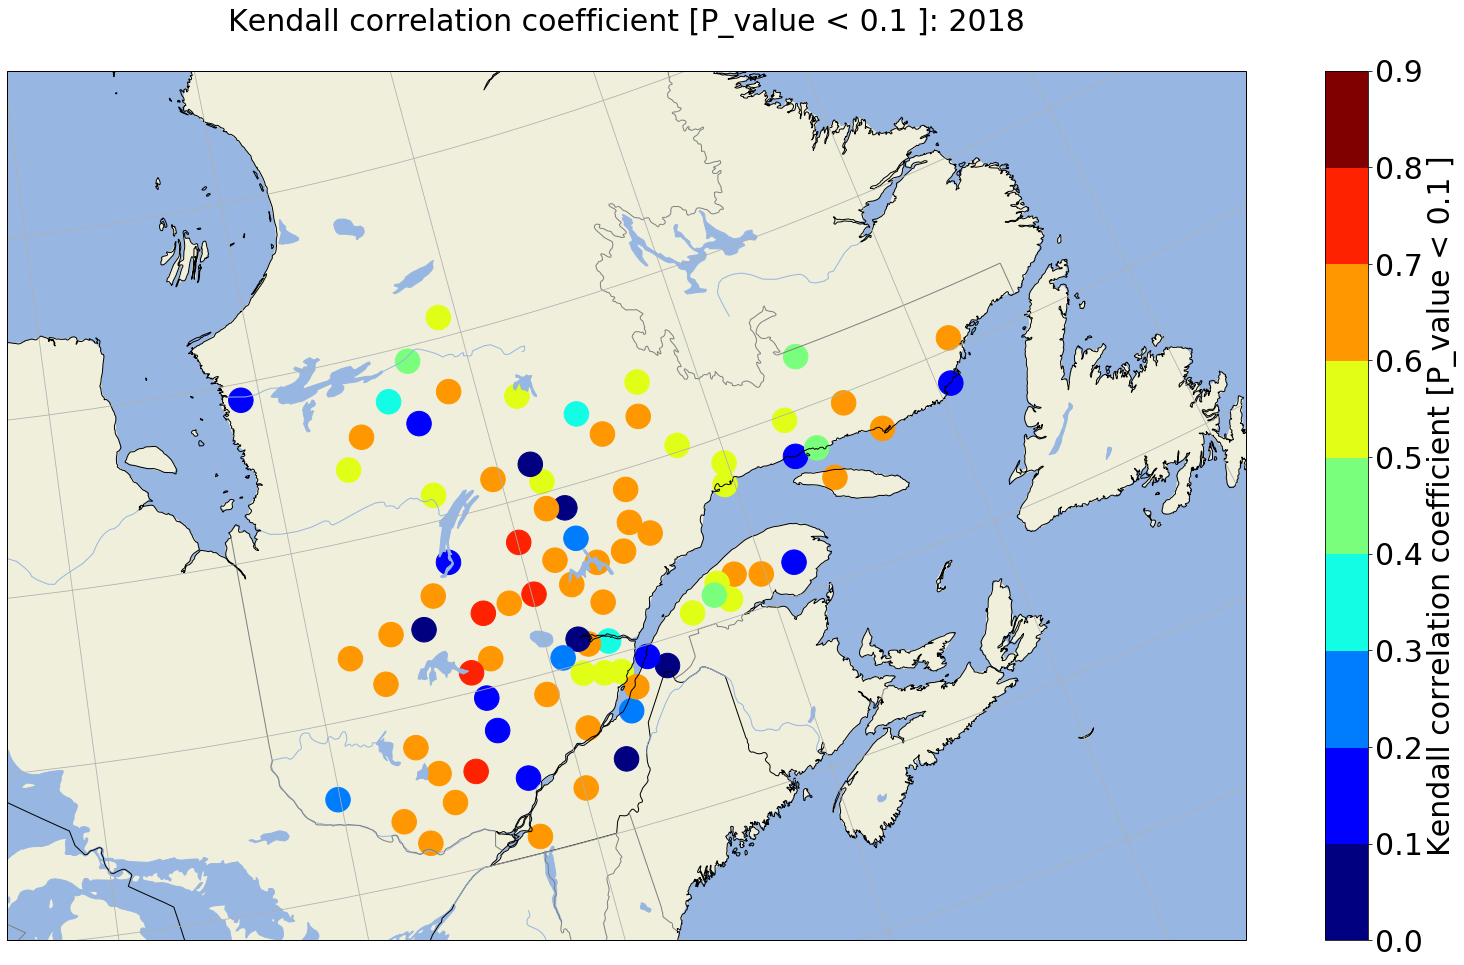

In [21]:
fig=plt.figure(figsize=(28,16), frameon=True) 
ax = plt.subplot(111, projection=ccrs.LambertConformal())
ax.set_extent([-85,-55,45,55])
 #ax.coastlines(resolution='110m');
ax.add_feature(cfeature.OCEAN.with_scale('50m'))      # couche ocean
ax.add_feature(cfeature.LAND.with_scale('50m'))       # couche land
ax.add_feature(cfeature.LAKES.with_scale('50m'))      # couche lac
  
ax.add_feature(cfeature.BORDERS.with_scale('50m'))    # couche frontieres
ax.add_feature(cfeature.RIVERS.with_scale('50m'))     # couche rivières
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',     # ajout de la couche cotière
                            facecolor='none', name='coastline')
ax.add_feature(coast, edgecolor='black')   
states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='10m',
            facecolor='none')
   
ax.add_feature(states_provinces, edgecolor='gray')

cmap = plt.cm.jet  # define the colormap
norm = matplotlib.colors.BoundaryNorm(np.arange(0,1,0.1), cmap.N)

# Plots the data onto map
plt.scatter(df_correlation['Lon'][(df_correlation['p_kendall'] < 0.1)], 
            df_correlation['Lat'][(df_correlation['p_kendall'] < 0.1)],
            alpha=1.,
            s=600, label="SR",
            c=df_correlation['tau'][(df_correlation['p_kendall'] < 0.1)],
            vmin=0,
            vmax=1,
            cmap=plt.get_cmap("jet"),
            norm=norm,
            transform=ccrs.PlateCarree())
       
ax.gridlines()
# Colorbar
fwi = df_corr_stations_ERA5['Correlation']
#tick_values = np.linspace(fwi.min(), fwi.max(), 11)
cbar = plt.colorbar()
#cbar.ax.set_yticklabels(["%d"%(v) for v in tick_values], fontsize=14)
cbar.set_label('Kendall correlation coefficient [P_value < 0.1 ]', fontsize=30)
string_title=u'Kendall correlation coefficient [P_value < 0.1 ]: 2018\n'
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontsize=30)

plt.title(string_title, size='xx-large', fontsize=30)
plt.savefig('K:/PROJETS/PROJET_FIRE_INDEX/figures/SOPFEU_Stations_in_Quebec_Kendall_Correlation_2018.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

## Compute RMSE using sklearn

In [22]:
from sklearn.metrics import mean_squared_error
from math import sqrt

df_rmse = pd.DataFrame()
rmse = []
for i in range(0,len(dataframe_stations.columns)): 
    # RMSE 
    rms = sqrt(mean_squared_error(dataframe_stations.iloc[:,i].dropna(axis=0, how='any'), FWI_kpts_model.iloc[:,i].dropna(axis=0, how='any')))     
    rmse.append(rms)
    
df_rmse['rmse'] = rmse
df_rmse['Lat'] = stations.latD.values
df_rmse['Lon'] = stations.lonD.values  

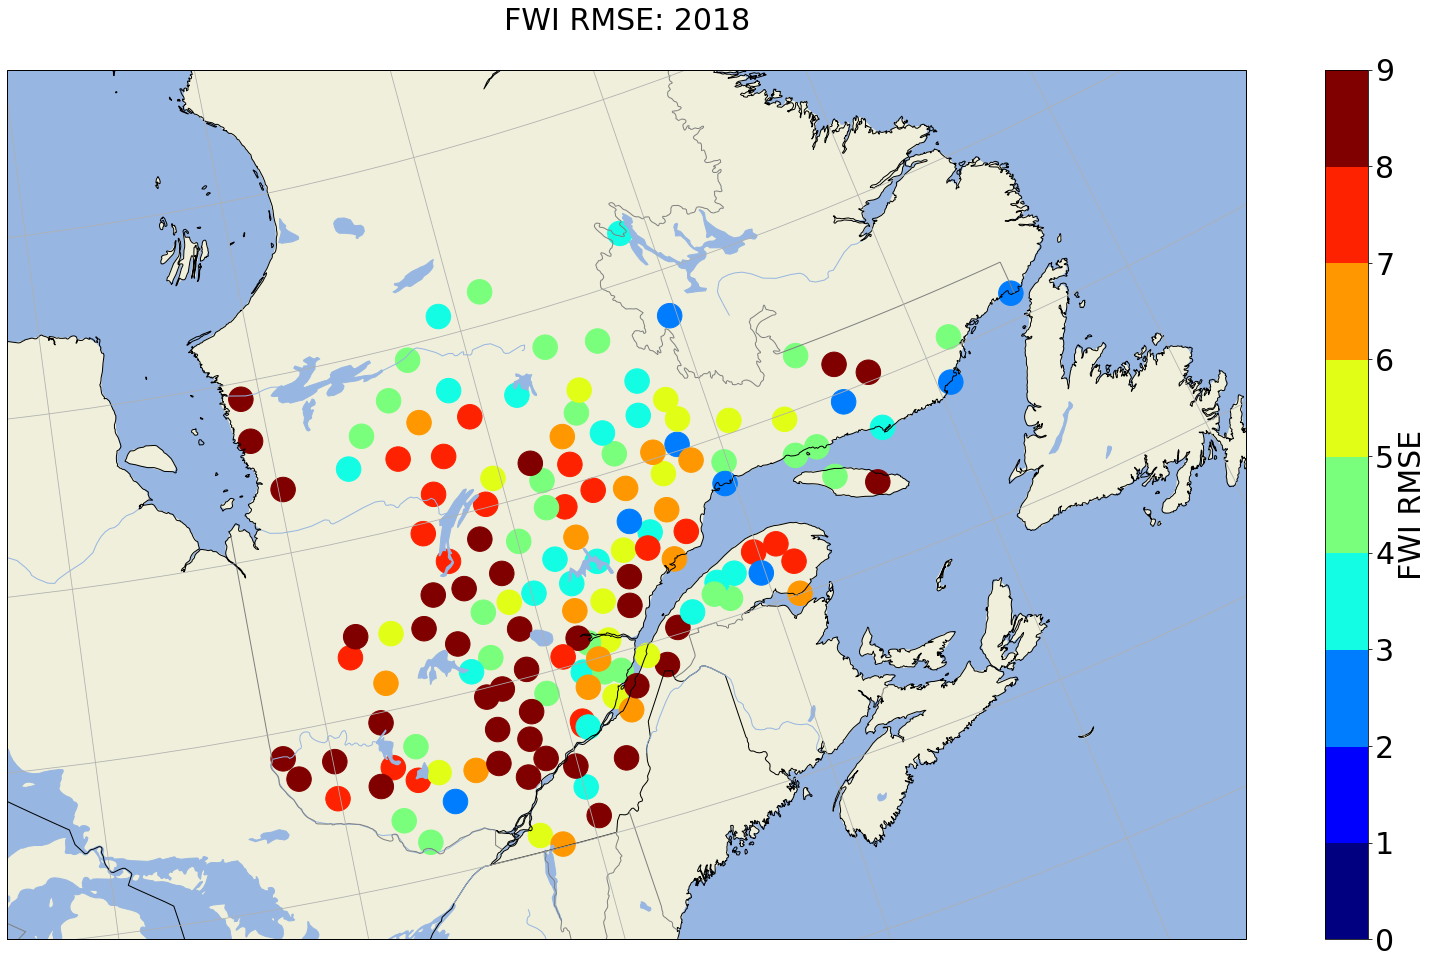

In [23]:
fig=plt.figure(figsize=(28,16), frameon=True) 
ax = plt.subplot(111, projection=ccrs.LambertConformal())
ax.set_extent([-85,-55,45,55])
 #ax.coastlines(resolution='110m');
ax.add_feature(cfeature.OCEAN.with_scale('50m'))      # couche ocean
ax.add_feature(cfeature.LAND.with_scale('50m'))       # couche land
ax.add_feature(cfeature.LAKES.with_scale('50m'))      # couche lac
  
ax.add_feature(cfeature.BORDERS.with_scale('50m'))    # couche frontieres
ax.add_feature(cfeature.RIVERS.with_scale('50m'))     # couche rivières
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',     # ajout de la couche cotière
                            facecolor='none', name='coastline')
ax.add_feature(coast, edgecolor='black')   
states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='10m',
            facecolor='none')
   
ax.add_feature(states_provinces, edgecolor='gray')

cmap = plt.cm.jet  # define the colormap
norm = matplotlib.colors.BoundaryNorm(np.arange(0,10,1), cmap.N)

# Plots the data onto map
plt.scatter(df_rmse['Lon'], 
            df_rmse['Lat'],
            alpha=1.,
            s=600, label="RMSE",
            c=df_rmse['rmse'],
            vmin=0,
            vmax=10,
            cmap=plt.get_cmap("jet"),
            norm=norm,
            transform=ccrs.PlateCarree())
       
ax.gridlines()
# Colorbar
fwi = df_corr_stations_ERA5['Correlation']
#tick_values = np.linspace(fwi.min(), fwi.max(), 11)
cbar = plt.colorbar()
#cbar.ax.set_yticklabels(["%d"%(v) for v in tick_values], fontsize=14)
cbar.set_label('FWI RMSE', fontsize=30)
string_title=u'FWI RMSE: 2018\n'
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontsize=30)

plt.title(string_title, size='xx-large', fontsize=30)
plt.savefig('K:/PROJETS/PROJET_FIRE_INDEX/figures/SOPFEU_Stations_in_Quebec_RMSE_2018.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

Text(0, 0.5, 'FWI ERA5 closest point')

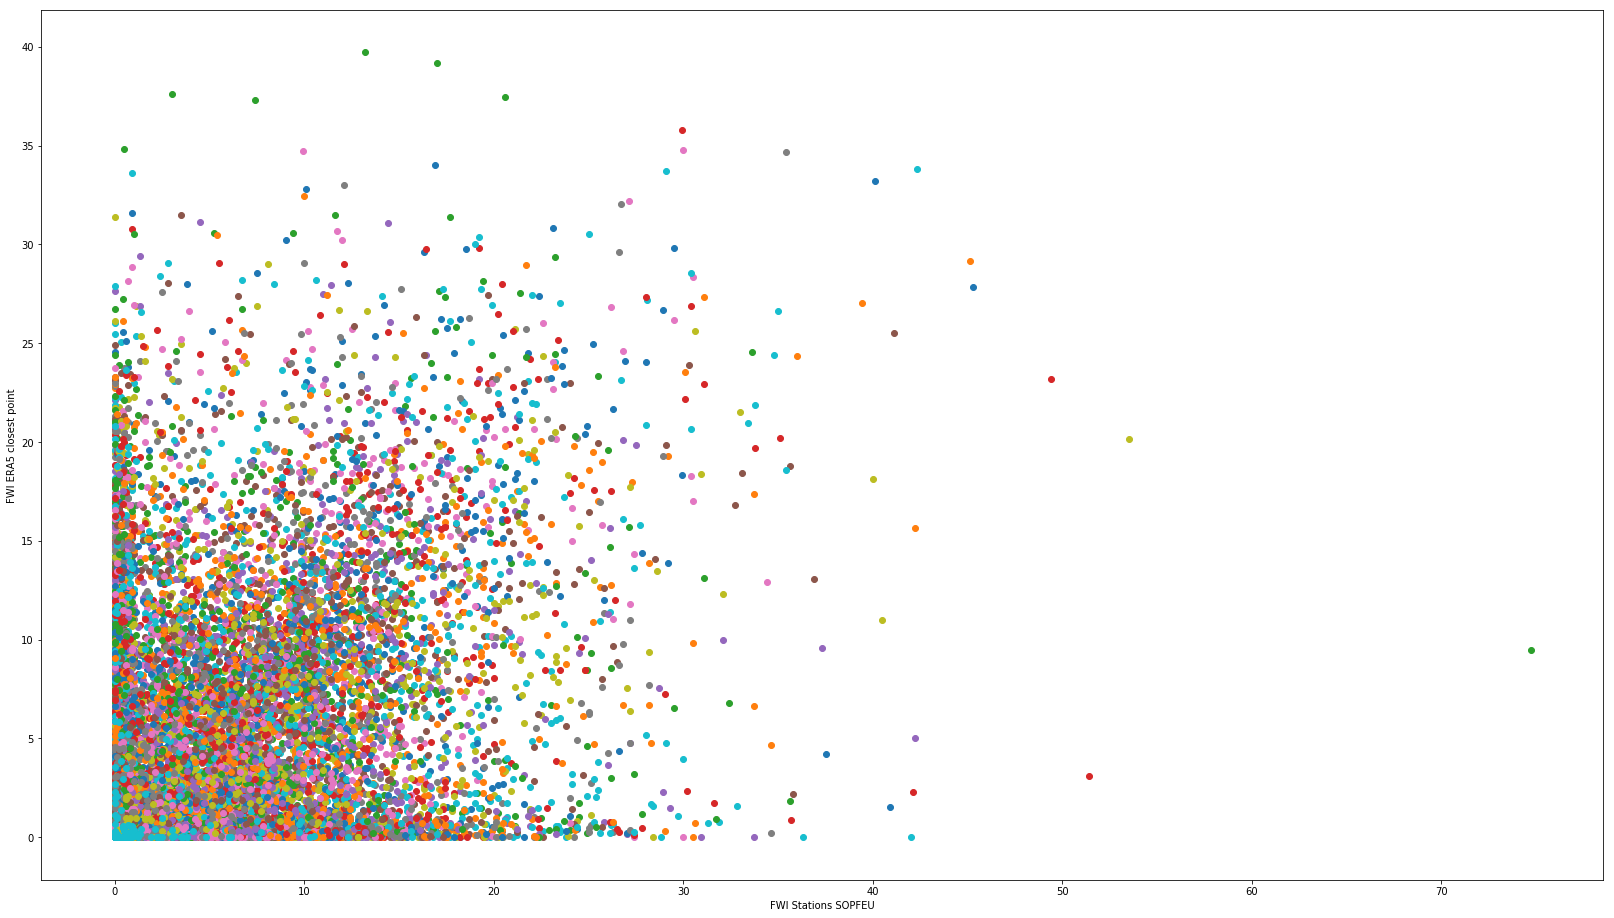

In [24]:
#dataframe_stations.corrwith(other=FWI_kpts_model)
fig=plt.figure(figsize=(28,16), frameon=True) 
for col in dataframe_stations.columns:
    plt.scatter(dataframe_stations[col], FWI_kpts_model[col], label=col)
#plt.legend(loc='best', fontsize=16)
plt.xlabel('FWI Stations SOPFEU')
plt.ylabel('FWI ERA5 closest point')